In [2]:
#%reset
import sys
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.interpolate import interp1d
from matplotlib import cm

# Two-hour test visualization

In [2]:
basedir = '/scratch/b/b380873/reff_fix/'
norad2mom_fi = xr.open_dataset(basedir + 'REFF_FIX_icon_tropic_0001_PL2.nc')
rad2mom_fi = xr.open_dataset(basedir + 'REFF_FIX_icon_tropic_0002_PL2.nc')

In [3]:
# Extract the time corresponding to the new effective radii from the old ones.
old_re_drop = norad2mom_fi.re_drop
old_re_ice = norad2mom_fi.re_ice
new_re_drop = rad2mom_fi.re_drop
new_re_ice = rad2mom_fi.re_ice

In [6]:
# Filter the ice effective radius at ~100, 200, 300, 400 hPa and 
# the droplet effective radius at ~500, 600, 700, and 800 hPa.
old_re = [[] for i in np.arange(8)]
new_re = [[] for i in np.arange(8)]
ll = [[18,21],[39,41],[52,53],[64,66],[74,76],[80,82],[91,93],[99,101]]

for i, l in enumerate(ll):
    if i < 4:
        temp = old_re_ice.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        old_re[i].append(temp.where(temp > 0).dropna(dim='ncells'))
        temp = new_re_ice.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        new_re[i].append(temp.where(temp > 0).dropna(dim='ncells'))
    else:
        temp = old_re_drop.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        old_re[i].append(temp.where(temp > 0).dropna(dim='ncells'))
        temp = new_re_drop.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        new_re[i].append(temp.where(temp > 0).dropna(dim='ncells'))
        

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Generate probability distributions of ice and droplet effective radii at different pressure levels.

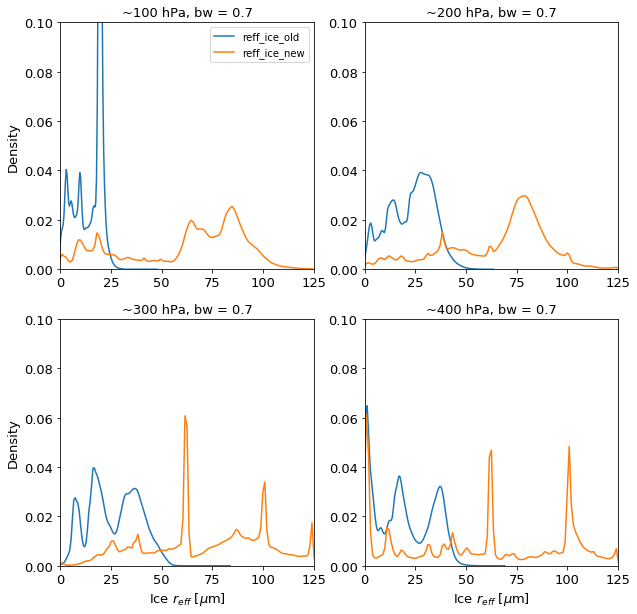

In [8]:
fs = 13
bw_param = 0.7
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
titre = ['~100 hPa, bw = ' + str(bw_param),'~200 hPa, bw = ' + str(bw_param),\
         '~300 hPa, bw = ' + str(bw_param),'~400 hPa, bw = ' + str(bw_param)]
lbl = ['reff_ice_old','_nolabel_','_nolabel_','_nolabel_',
       'reff_ice_new','_nolabel_','_nolabel_','_nolabel_']

for i, axes in enumerate(ax.reshape(-1)):
    sns.kdeplot(old_re[i][0],bw=bw_param,label=lbl[i],ax=axes)
    sns.kdeplot(new_re[i][0],bw=bw_param,label=lbl[i+4],ax=axes)
    axes.set_title(titre[i],fontsize=fs)
    axes.set_ylim([0,0.1])
    axes.set_xlim([0,125])
    axes.tick_params('both',labelsize=fs)
    if i == 0 or i == 2:
        axes.set_ylabel('Density',fontsize=fs)
    if i == 2 or i == 3:
        axes.set_xlabel(r'Ice $r_{eff}$ [$\mu$m]',fontsize=fs)
        
#fig.savefig('ice-reff-kde.pdf',bbox_inches='tight')
plt.show()

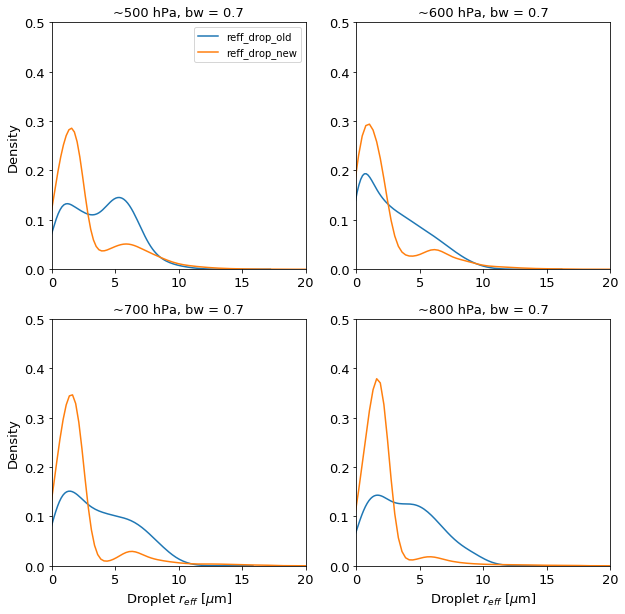

In [9]:
bw_param = 0.7
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
titre = ['~500 hPa, bw = ' + str(bw_param),'~600 hPa, bw = ' + str(bw_param),\
         '~700 hPa, bw = ' + str(bw_param),'~800 hPa, bw = ' + str(bw_param)]
lbl = ['reff_drop_old','_nolabel_','_nolabel_','_nolabel_',
       'reff_drop_new','_nolabel_','_nolabel_','_nolabel_']

for i, axes in enumerate(ax.reshape(-1)):
    sns.kdeplot(old_re[i+4][0],bw=bw_param,label=lbl[i],ax=axes)
    sns.kdeplot(new_re[i+4][0],bw=bw_param,label=lbl[i+4],ax=axes)
    axes.set_title(titre[i],fontsize=fs)
    axes.set_ylim([0,0.5])
    axes.set_xlim([0,20])
    axes.tick_params('both',labelsize=fs)
    if i == 0 or i == 2:
        axes.set_ylabel('Density',fontsize=fs)
    if i == 2 or i == 3:
        axes.set_xlabel(r'Droplet $r_{eff}$ [$\mu$m]',fontsize=fs)

#fig.savefig('droplet-reff-kde.pdf',bbox_inches='tight')
plt.show()

### Generate mean vertical profiles of ice and droplet effective radii

In [11]:
# Calculate the mean over both space and time. 
# It seems to be faster if this is done in two separate commands.
s1 = old_re_ice.mean(dim='ncells')
s2 = old_re_drop.mean(dim='ncells')
s3 = new_re_ice.mean(dim='ncells')
s4 = new_re_drop.mean(dim='ncells')

field = [s1.mean(dim='time'),s2.mean(dim='time'),s3.mean(dim='time'),s4.mean(dim='time')]

del s1
del s2
del s3
del s4

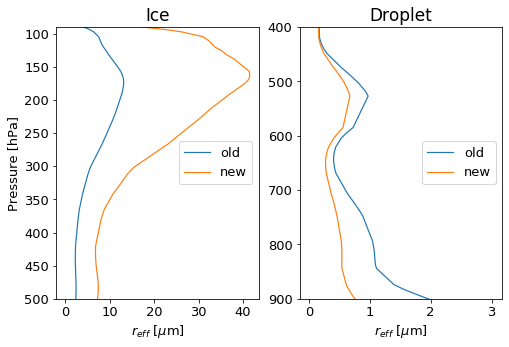

In [13]:
bw_param = 0.7
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5))
titre = ['Ice','Droplet']
lbl = ['old','old','new','new']
plev = norad2mom_fi.plev

for i, axes in enumerate(ax.reshape(-1)):
    axes.plot(field[i],plev/100.,linewidth=1.2,label=lbl[i])
    axes.plot(field[i+2],plev/100.,linewidth=1.2,label=lbl[i+2])
    axes.set_title(titre[i],fontsize=fs+4)
    if i == 0:
        axes.set_ylim([90,500])
    else:
        axes.set_ylim([400,900])
    axes.legend(fontsize=fs,loc='center right')
    axes.tick_params('both',labelsize=fs)
    if i == 0:
        axes.set_ylabel('Pressure [hPa]',fontsize=fs)
    axes.set_xlabel(r'$r_{eff}$ [$\mu$m]',fontsize=fs)
    axes.invert_yaxis()

#fig.savefig('../output/ice-droplet-reff-profiles.pdf',bbox_inches='tight')
plt.show()

### Generate probability distributions of ice crystal and droplet number concentrations at different pressure levels

In [ ]:
# Load the CDNC and ICNC from the two simulations
old_cdnc = norad2mom_fi.acdnc
old_inc = norad2mom_fi.ainc
new_cdnc = rad2mom_fi.acdnc
new_inc = rad2mom_fi.ainc

In [ ]:
# Filter the ice crystal number concentration at ~100, 200, 300, 400 hPa and 
# the cloud droplet number concentration at ~500, 600, 700, and 800 hPa.
old_num = [[] for i in np.arange(8)]
new_num = [[] for i in np.arange(8)]
ll = [[18,21],[39,41],[52,53],[64,66],[74,76],[80,82],[91,93],[99,101]]

for i, l in enumerate(ll):
    if i < 4:
        temp = old_inc.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        old_num[i].append(temp.where(temp > 0).dropna(dim='ncells'))
        temp = new_inc.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        new_num[i].append(temp.where(temp > 0).dropna(dim='ncells'))
    else:
        temp = old_cdnc.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        old_num[i].append(temp.where(temp > 5e7).dropna(dim='ncells'))
        temp = new_cdnc.isel(plev=slice(l[0],l[1])).mean(dim={'plev','time'})
        new_num[i].append(temp.where(temp > 0).dropna(dim='ncells'))

In [ ]:
fs = 13
bw_param = 0.6
fig3, ax3 = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
titre = ['~100 hPa, bw = ' + str(bw_param),'~200 hPa, bw = ' + str(bw_param),\
         '~300 hPa, bw = ' + str(bw_param),'~400 hPa, bw = ' + str(bw_param)]
lbl = ['ICNC_ice_old','_nolabel_','_nolabel_','_nolabel_',
       'ICNC_ice_new','_nolabel_','_nolabel_','_nolabel_']

for i, axes in enumerate(ax3.reshape(-1)):
    sns.kdeplot(old_num[i][0],bw=bw_param,label=lbl[i],ax=axes)
    sns.kdeplot(new_num[i][0],bw=bw_param,label=lbl[i+4],ax=axes)
    axes.set_title(titre[i],fontsize=fs)
    #axes.set_ylim([0,0.25])
    #axes.set_xlim([0,125])
    axes.tick_params('both',labelsize=fs)
    if i == 0 or i == 2:
        axes.set_ylabel('Density',fontsize=fs)
    if i == 2 or i == 3:
        axes.set_xlabel(r'Ice crystal number concentration [m$^{-3}$]',fontsize=fs)
        
#fig.savefig('inc-kde.pdf',bbox_inches='tight')
plt.show()

In [ ]:
fs = 13
bw_param = 1
fig3, ax3 = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
titre = ['~500 hPa, bw = ' + str(bw_param),'~600 hPa, bw = ' + str(bw_param),\
         '~700 hPa, bw = ' + str(bw_param),'~800 hPa, bw = ' + str(bw_param)]
lbl = ['CDNC_ice_old','_nolabel_','_nolabel_','_nolabel_',
       'CDNC_ice_new','_nolabel_','_nolabel_','_nolabel_']

for i, axes in enumerate(ax3.reshape(-1)):
    sns.kdeplot(old_num[i+4][0]/10**6,bw=bw_param,label=lbl[i],ax=axes)
    sns.kdeplot(new_num[i+4][0]/10**6,bw=bw_param,label=lbl[i+4],ax=axes)
    axes.set_title(titre[i],fontsize=fs)
    #axes.set_ylim([0,0.25])
    #axes.set_xlim([0,125])
    axes.tick_params('both',labelsize=fs)
    if i == 0 or i == 2:
        axes.set_ylabel('Density',fontsize=fs)
    if i == 2 or i == 3:
        axes.set_xlabel(r'Ice crystal number concentration [cm$^{-3}$]',fontsize=fs)
    
#fig.savefig('cdnc-kde.pdf',bbox_inches='tight')
plt.show()

### Generate mean vertical profiles of ice crystal and droplet number concentrations

In [ ]:
# Calculate the mean over both space and time. 
# It seems to be faster if this is done in two separate commands.
s1 = old_cdnc.mean(dim='ncells')
s2 = old_inc.mean(dim='ncells')
s3 = new_cdnc.mean(dim='ncells')
s4 = new_inc.mean(dim='ncells')

field = [s1.mean(dim='time'),s2.mean(dim='time'),s3.mean(dim='time'),s4.mean(dim='time')]

del s1
del s2
del s3
del s4

In [ ]:
bw_param = 0.7
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5))
titre = ['Ice','Droplet']
lbl = ['old','old','new','new']
plev = rad1mom_fi.plev

for i, axes in enumerate(ax.reshape(-1)):
    axes.plot(field[i]/10**9,plev/100.,linewidth=1.2,label=lbl[i])
    axes.plot(field[i+2],plev/100.,linewidth=1.2,label=lbl[i+2])
    axes.set_title(titre[i],fontsize=fs+4)
    if i == 0:
        axes.set_ylim([90,500])
    else:
        axes.set_ylim([400,900])
    axes.legend(fontsize=fs,loc='center right')
    axes.tick_params('both',labelsize=fs)
    if i == 0:
        axes.set_ylabel('Pressure [hPa]',fontsize=fs)
    axes.set_xlabel(r'$N$ [m$^{-3}$]',fontsize=fs)
    axes.invert_yaxis()

#fig.savefig('ice-droplet-reff-profiles.pdf',bbox_inches='tight')
plt.show()

# 24-hour visualization

In [3]:
# These two functions calculate the mean vertical profile over many files.
def file_prefix(j):
    if len(str(j)) == 1:
       return '000'
    elif len(str(j)) == 2:
       return '00'
    elif len(str(j)) == 3:
       return '0'
    else:
       return 'Inappropriate length of input to file_prefix'

# basedir is the base directory where the nc files are found.
# tag is how to label the output npy.
# startindx and endinx are the files over which to iterate.
# var is which variable to pull from the input file.
# in-cloud is a boolean whether to weight by cloud fraction or not.
def meanProfile(basedir, tag, startindx, endindx, var, f):
    # How many vertical levels?
    c = 120
    suffix1 = '_PL2'
    RE = np.zeros((24,c))

    for i in np.arange(startindx,endindx):
        print(i)
        prefix = file_prefix(i)
        reff = xr.open_dataset(basedir + 'CLCONV_3D_icon_tropic_' + prefix + str(i) + suffix1 + '.nc')
        if f == True:
            # Divide by the cloud fraction to get the in-cloud value. Cloud fraction is [%] so multiply by 100.
            reff_clch = reff[var].isel(time=0)/reff['clc'].isel(time=0)
            # Two lines below to mask infinity - where cld fraction = 0 - and to omit NaNs in the mean thereafter. 
            reff_clch = reff_clch.where(np.isinf(reff_clch) == False)
            RE[i-startindx] = reff_clch.mean(dim={'ncells'},skipna=True)
            suffix = '-in-cloud'
        else:
            RE[i-startindx] = reff[var].isel(time=0).mean(dim={'ncells'})
            suffix = ''
        
    print('Saving hourly mean profiles from ' + basedir + '...')
    np.save('../output/' + var.upper() + '_' + tag + '_PL2' + suffix + '.npy',RE)
    return RE

### Generate mean vertical profiles of ice and droplet effective radii, both total and in-cloud

In [11]:
# Use the functions above to calculate mean effective radius and number concentrations
# from the two simulations or load the already calculated values.

#re_ice_rad2mom = meanProfile('/scratch/b/b380873/reff_fix/24h_TRUE/', 'rad2mom', 6, 30, 're_ice', True)
#re_drop_rad2mom = meanProfile('/scratch/b/b380873/reff_fix/24h_TRUE/', 'rad2mom', 6, 30, 're_drop', True)
#re_ice_2mom = meanProfile('/scratch/b/b380873/reff_fix/24h_FALSE/', '2mom', 6, 30, 're_ice', True)
#re_drop_2mom = meanProfile('/scratch/b/b380873/reff_fix/24h_FALSE/', '2mom', 6, 30, 're_drop', True)

#icnc_2mom = meanProfile(basedir, '2mom', 6, 30, 'ainc', False)
#cdnc_2mom = meanProfile(basedir, '2mom', 6, 30, 'acdnc', False)

suffix = '' # '-in-cloud'
re_ice_2mom = np.load('../output/RE_ICE_2mom_PL2' + suffix + '.npy') 
re_drop_2mom = np.load('../output/RE_DROP_2mom_PL2' + suffix + '.npy')
re_ice_rad2mom = np.load('../output/RE_ICE_rad2mom_PL2' + suffix + '.npy')
re_drop_rad2mom = np.load('../output/RE_DROP_rad2mom_PL2' + suffix + '.npy')

inc_2mom = np.load('../output/AINC_2mom_PL2' + suffix + '.npy')
cdnc_2mom = np.load('../output/ACDNC_2mom_PL2' + suffix + '.npy')
inc_rad2mom = np.load('../output/AINC_rad2mom_PL2' + suffix + '.npy')
cdnc_rad2mom = np.load('../output/ACDNC_rad2mom_PL2' + suffix + '.npy')

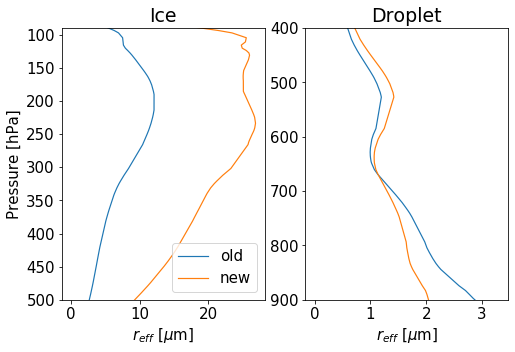

In [9]:
# Plot the mean effective radii profiles
basedir = '/scratch/b/b380873/reff_fix/24h_TRUE/'
field = [np.nanmean(re_ice_2mom,axis=0), np.nanmean(re_drop_2mom,axis=0),
         np.nanmean(re_ice_rad2mom,axis=0), np.nanmean(re_drop_rad2mom,axis=0)]
titre = ['Ice','Droplet']
lbl = ['old','old','new','new']
fs = 15
plev = xr.open_dataset(basedir + 'CLCONV_3D_icon_tropic_0006_PL2.nc').plev

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5))
for i, axes in enumerate(ax.reshape(-1)):
    axes.plot(field[i],plev/100.,linewidth=1.2,label=lbl[i])
    axes.plot(field[i+2],plev/100.,linewidth=1.2,label=lbl[i+2])  #[0]
    axes.set_title(titre[i],fontsize=fs+4)
    if i == 0:
        axes.set_ylim([90,500])
    else:
        axes.set_ylim([400,900])
    axes.tick_params('both',labelsize=fs)
    if i == 0:
        axes.set_ylabel('Pressure [hPa]',fontsize=fs)
        axes.legend(fontsize=fs,loc='lower right')
    axes.set_xlabel(r'$r_{eff}$ [$\mu$m]',fontsize=fs)
    axes.invert_yaxis()
    
fig.savefig('../output/ice-droplet-reff-profiles2' + suffix + '.pdf',bbox_inches='tight')

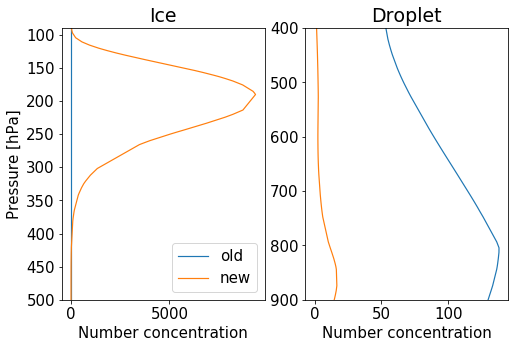

In [17]:
# Plot the mean ICNC and CDNC profiles. Units are [m-3] initially.
field = [np.nanmean(inc_2mom,axis=0)/10**3, np.nanmean(cdnc_2mom,axis=0)/10**6,
        np.nanmean(inc_rad2mom,axis=0)/10**3, np.nanmean(cdnc_rad2mom,axis=0)/10**6]

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,5))
for i, axes in enumerate(ax.reshape(-1)):
    axes.plot(field[i],plev/100.,linewidth=1.2,label=lbl[i])
    axes.plot(field[i+2],plev/100.,linewidth=1.2,label=lbl[i+2])  #[0]
    axes.set_title(titre[i],fontsize=fs+4)
    if i == 0:
        axes.set_ylim([90,500])
    else:
        axes.set_ylim([400,900])
    axes.tick_params('both',labelsize=fs)
    if i == 0:
        axes.set_ylabel('Pressure [hPa]',fontsize=fs)
        axes.legend(fontsize=fs,loc='lower right')
    axes.set_xlabel(r'Number concentration',fontsize=fs)
    axes.invert_yaxis()
    
#fig.savefig('../output/icnc-cdnc-profiles2' + suffix + '.pdf',bbox_inches='tight')

# Comparison of old and new reff parameterization in radiation
### Reproducing this as Jan Kretzschmar

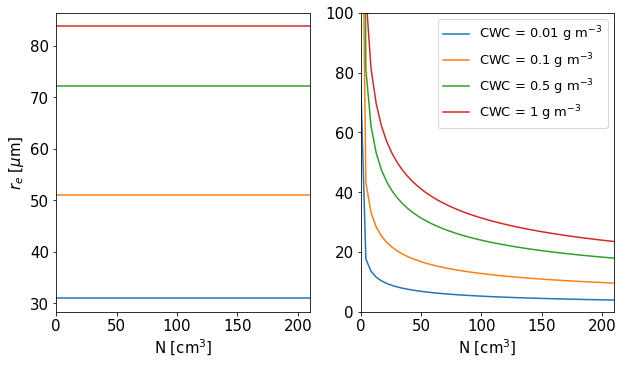

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5.5))
# Old parameterization
fs = 15
a0 = 83.8
b0 = 0.216
# in [cm-3]
N = np.linspace(0.1,210,50)
# in [g m-3]
iwc = [0.01, 0.1, 0.5, 1]
re_old = np.zeros((len(iwc),len(N)))
for indx, i in enumerate(iwc):
    re = a0*i**b0
    ax[0].plot(N,re*np.ones(len(N)))
    re_old[indx] = re*np.ones(len(N))
ax[0].set_xlim([0,210])
ax[0].set_xlabel(r'N [cm$^{3}$]',fontsize=fs)
ax[0].set_ylabel(r'$r_e$ [$\mu$m]',fontsize=fs)
ax[0].tick_params('both',labelsize=fs)
    
# New parameterization, using parameters from the ice_cosmo5 type in mo_
nu = 0
mu = 0.333333
ageo = 0.835
bgeo = 0.39
part1 = ageo/2*(gamma((nu + 1)/mu)/gamma((nu + 2)/mu))**bgeo
part2 = gamma((3*bgeo + nu + 1)/mu)/gamma((2*bgeo + nu + 1)/mu)
re_new = np.zeros((len(iwc),len(N)))
# N [=] m-3, i [=] g m-3
# Not totally clear on the factors of 10 below. I have pulled them from line 285 of mo_newcld_optics in the reff_fix_Jan branch.
for indx, i in enumerate(iwc):
    re = part1*part2*((i/10**3)/(N*10**6))**bgeo*10**6
    ax[1].plot(N,re,label='CWC = '+str(i) + ' g m$^{-3}$')
    re_new[indx] = re
ax[1].set_xlim([0,210])
ax[1].set_ylim([0,100])
ax[1].set_xlabel(r'N [cm$^{3}$]',fontsize=fs)
ax[1].tick_params('both',labelsize=fs)
ax[1].legend(loc='upper right',fontsize=fs-2)

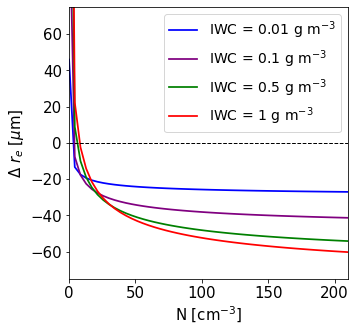

In [5]:
fig = plt.figure(figsize=(5,5))
farbe = ['blue','purple','green','red']
for i in np.arange(4):
    plt.plot(N,re_new[i] - re_old[i],linewidth=1.75,color=farbe[i],label='IWC = '+str(iwc[i]) + ' g m$^{-3}$')
plt.plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
plt.gca().set_xlim([0,210])
plt.gca().set_ylim([-75,75])
plt.gca().set_xlabel(r'N [cm$^{-3}$]',fontsize=fs)
plt.gca().set_ylabel('$\Delta$ $r_e$ [$\mu$m]',fontsize=fs)
plt.gca().tick_params('both',labelsize=fs)
plt.legend(loc='upper right',fontsize=fs-1)
#fig.savefig('../output/delta-re.pdf',bbox_inches='tight')

## How much does this delta r_eff propagate to the mass extinction coefficient?

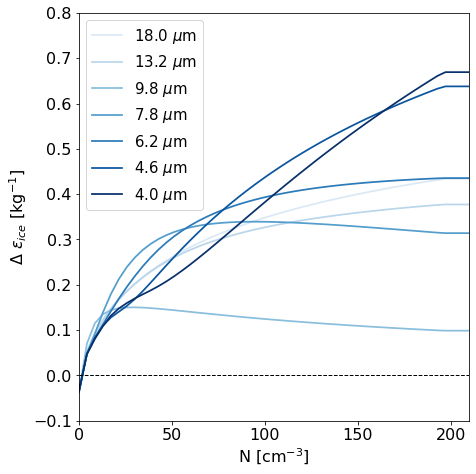

In [6]:
cldopt = xr.open_dataset('/work/bb1018/b380873/rrtm/rrtm_cldopt.nc')
wavel = cldopt.wavelength
waven = cldopt.wavenumber
ri = cldopt.re_crystal
# 30 wavelengths, 61 effective radii
kappa = cldopt.extinction_per_mass_crystal
fs = 16

# Generate an interpolation function kappa = f(reff)
cubic_interp = interp1d(ri,kappa,kind='cubic')
wavel_sub = np.arange(2,16,2)
cmapz = [cm.Blues(np.linspace(0,1,len(wavel_sub)+1)), cm.Purples(np.linspace(0,1,len(wavel_sub))+1),\
         cm.Greens(np.linspace(0,1,len(wavel_sub))+1), cm.Reds(np.linspace(0,1,len(wavel_sub))+1)]
ls = ['-','-.','--','.']
fig = plt.figure(figsize=(7,7.5))
for c, r_new, r_old in zip([0],re_new, re_old):
    # Where r_new or r_old are less than the tabulated minimum set them to min.
    r_new[np.argwhere((r_new < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
    r_old[np.argwhere((r_old < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
    
    # Where r_new or r_old are greater than the tabulated maximum set them to max.
    r_new[np.argwhere((r_new > np.nanmax(ri)))[:,0]] = np.nanmax(ri)
    r_old[np.argwhere((r_old > np.nanmax(ri)))[:,0]] = np.nanmax(ri)
        
    # Interpolate the r_new and r_old values onto the fixed RRTM kappa = f(reff) function.
    kappa_new_cubic = cubic_interp(r_new)
    kappa_old_cubic = cubic_interp(r_old)
    for indx, i in enumerate(wavel_sub):
        plt.plot(N,kappa_new_cubic[i] - kappa_old_cubic[i],linewidth=1.75,linestyle=ls[c],\
                 label='{0:3.1f}'.format(wavel[i].values)+r' $\mu$m',color=cmapz[c][indx+1])
        
plt.plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
plt.gca().set_xlim([0,210])
plt.gca().set_ylim([-0.1,0.8])
plt.gca().set_xlabel(r'N [cm$^{-3}$]',fontsize=fs)
plt.gca().set_ylabel('$\Delta$ $\epsilon_{ice}$ [kg$^{-1}$]',fontsize=fs)
plt.gca().tick_params('both',labelsize=fs)
plt.legend(loc='upper left',fontsize=fs-1)
fig.savefig('../output/delta-epsilon_ice.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(5,5))
for i in np.arange(4):
    plt.plot(N,re_new[i] - re_old[i],linewidth=1.75,label='IWC = '+str(iwc[i]) + ' g m$^{-3}$')
plt.plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
plt.gca().set_xlim([0,210])
plt.gca().set_ylim([-75,75])
plt.gca().set_xlabel(r'N [cm$^{3}$]',fontsize=fs)
plt.gca().set_ylabel('$\Delta$ $r_e$ [$\mu$m]',fontsize=fs)
plt.gca().tick_params('both',labelsize=fs)
plt.legend(loc='upper right',fontsize=fs-1)
#fig.savefig('../output/delta-kappa.pdf',bbox_inches='tight')